<h1 style="color:white;">AI for Medicine and Healthcare | Assignment 2</h1>
<h2 style="color:crimson;">Chest X-ray classification with CNN models</h2>
<h3 style="color:white;">Team: Names, IDs</h3>
<ul>
    <li style="color:royalblue;">HAMZA SAMI MOHAMMAD ALSAWAFTAH, ID: 161395</li>
    <li style="color:royalblue;">NIDAL KHALED ABDEL HAMEED SHAHIN, ID: 162278</li>
</ul>
<h3 style="color:white;">Model: PyTorch Models: MobileNet-V2 & DenseNet-121</h3>

# Libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Class Distribution & Balance Check

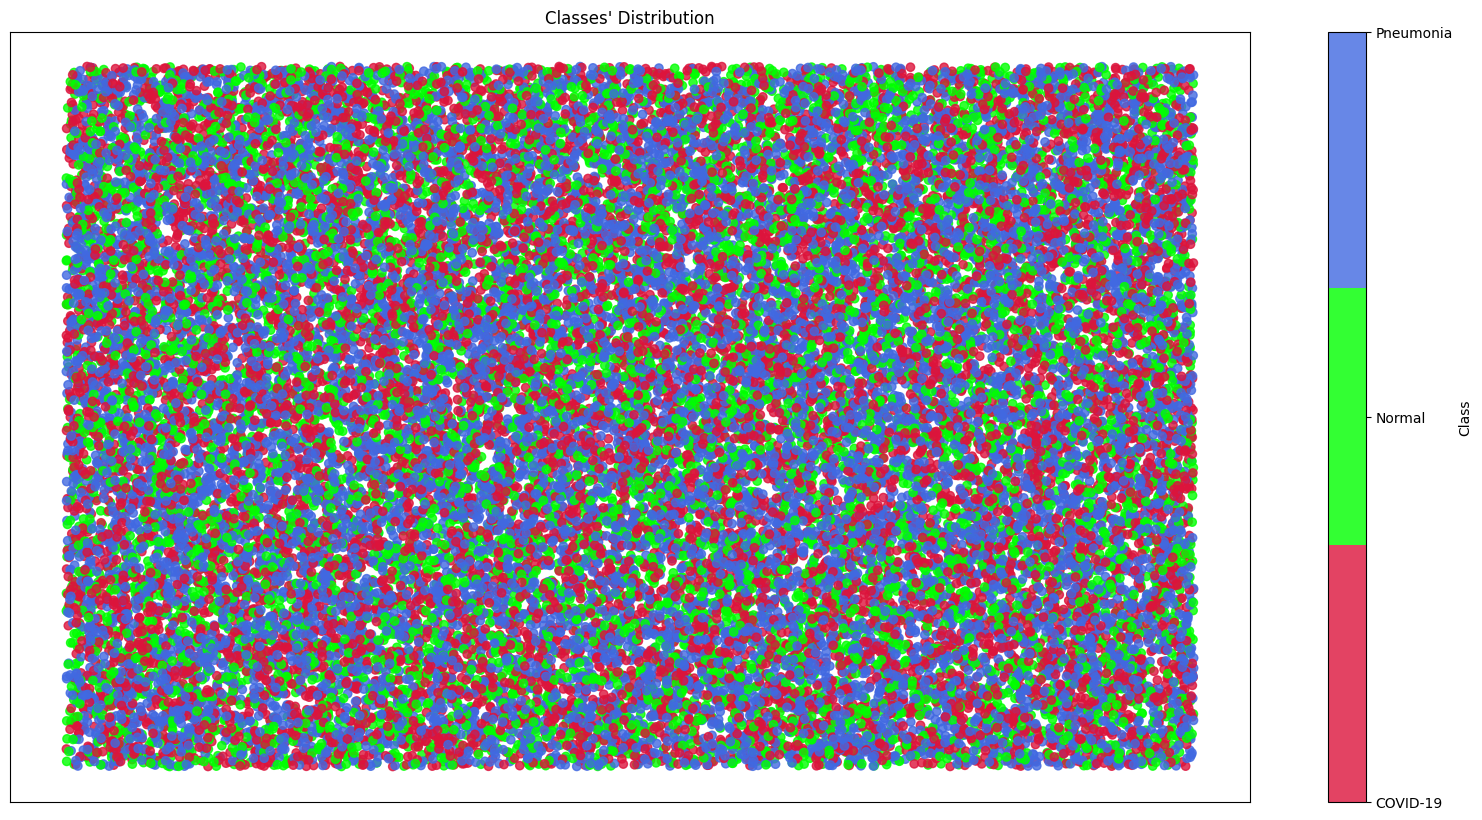

In [ ]:
# Class distribution visualization (same as before)
labels_file = "/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/labels.csv"

def read_labels(file_path):
    df = pd.read_csv(file_path)
    return df["label"].tolist()

all_labels = read_labels(labels_file)
encoder = LabelEncoder()
label_indices = encoder.fit_transform(all_labels)

np.random.seed(42)
x_coords = np.random.uniform(0, 1, len(all_labels))
y_coords = np.random.uniform(0, 1, len(all_labels))

colors = ['crimson', 'lime', 'royalblue']
custom_cmap = ListedColormap(colors[:len(encoder.classes_)])

plt.figure(figsize=(20, 10))
scatter = plt.scatter(x_coords, y_coords, c=label_indices, cmap=custom_cmap, alpha=0.8)
plt.colorbar(scatter, ticks=range(len(encoder.classes_)), label="Class").ax.set_yticklabels(encoder.classes_)
plt.xticks([])
plt.yticks([])
plt.title("Classes' Distribution")
plt.show()

Label Counts:
label
COVID-19     11956
Pneumonia    11263
Normal       10701
Name: count, dtype: int64


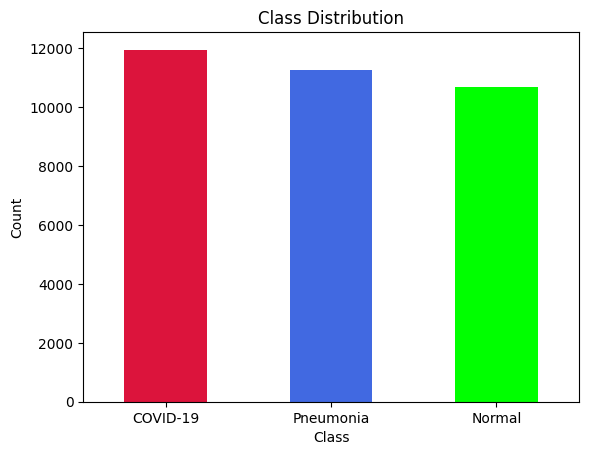

In [ ]:
DF = pd.read_csv(labels_file)
labels_counts = DF['label'].value_counts()
print("Label Counts:")
print(labels_counts)
labels_counts.plot(kind='bar', color=['crimson', 'royalblue', 'lime'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Data Preperation & Transformation

In [ ]:
class custom_dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_mapping = {
            'Normal': 0,
            'COVID-19': 1,
            'Pneumonia': 2
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        label = self.label_mapping[label]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def prepare_dataset(data_dir, label_file):
    image_paths = []
    labels = []

    try:
        df = pd.read_csv(label_file)
    except FileNotFoundError:
        print(f"{label_file} was not found.")
        return image_paths, labels

    for _, row in df.iterrows():
        image_name = row['filename']
        label = row['label']

        image_path = os.path.join(data_dir, image_name)
        if os.path.exists(image_path):
            image_paths.append(image_path)
            labels.append(label)
        else:
            print(f"{image_path} does not exist.")

    return image_paths, labels

In [ ]:
# compute mean and std
train_labels = pd.read_csv("/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/train_labels.csv")

# classes' ranges in the csv file
normal_range = range(0, 6849)
covid_range = range(6849, 14507)
pneumonia_range = range(14507, 21716)

# shuffling and selecting 3000 images from each class
selected_normal = random.sample(normal_range, 3000)
selected_covid = random.sample(covid_range, 3000)
selected_pneumonia = random.sample(pneumonia_range, 3000)
selected_indices = set(selected_covid + selected_normal + selected_pneumonia)

# loading selected images
temp_list = []
for idx in selected_indices:
    filename = train_labels.iloc[idx]['filename']
    img_path = os.path.join('/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/train', filename)
    img = Image.open(img_path)
    temp_list.append(img)

# images -> tensors
img_tensor = transforms.ToTensor()
images_as_tensors = torch.stack([img_tensor(img) for img in temp_list])

# computing mean and std
Mean = images_as_tensors.mean().item()
Std = images_as_tensors.std().item()

print(f"Mean: {Mean}")
print(f"Standard Deviation (std): {Std}")

Mean: 0.5119743943214417
Standard Deviation (std): 0.24813982844352722


In [ ]:
# MobileNet/DenseNet expect 3-channel images -> grayscale to RGB
transform_rgb = transforms.Compose([
    transforms.Resize(224), # to match the models' architecture
    transforms.Grayscale(num_output_channels=3),  # to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[Mean, Mean, Mean], std=[Std, Std, Std])
])

# preparing datasets
train_image_paths, train_labels = prepare_dataset("/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/train", "/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/train_labels.csv")
dev_image_paths, dev_labels = prepare_dataset("/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/dev", "/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/dev_labels.csv")
test_image_paths, test_labels = prepare_dataset("/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/test", "/kaggle/input/covid-qu-ex-dataset-zip/CNP_DS/test_labels.csv")

# creating the datasets
train_dataset = custom_dataset(train_image_paths, train_labels, transform_rgb)
dev_dataset = custom_dataset(dev_image_paths, dev_labels, transform_rgb)
test_dataset = custom_dataset(test_image_paths, test_labels, transform_rgb)

# finally, creating DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Models Initialization

In [ ]:
def initialize_model(model_name, num_classes=3):
    if model_name == "mobilenet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "densenet":
        model = models.densenet121(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError("Invalid model name")

    return model

In [ ]:
mobilenet = initialize_model("mobilenet")
densenet = initialize_model("densenet")

# to GPU (cuda), if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)
densenet = densenet.to(device)

# Training, Validation & Trends Comparisons

In [ ]:
def train_model(model, train_loader, dev_loader, criterion, optimizer, device, num_epochs=10, model_name=""):
    best_f1 = 0
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        # Training Phase
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # calculating training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        metrics['train_loss'].append(epoch_loss)
        metrics['train_acc'].append(epoch_acc)
        metrics['train_f1'].append(epoch_f1)

        # Validation Phase
        val_loss, val_acc, val_f1 = evaluate_model(model, dev_loader, criterion, device)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_f1'].append(val_f1)

        # Savin the Best Model for Evaluation
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_{model_name}.pt")
            print(f"New best model saved with Validation F1 = {val_f1:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    return metrics

In [ ]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return loss, acc, f1

In [ ]:
criterion = nn.CrossEntropyLoss()

# MobileNet training
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.0001)
print("Training MobileNet...\n")
metrics_mobilenet = train_model(
    mobilenet, train_loader, dev_loader, criterion,
    optimizer_mobilenet, device, num_epochs=10, model_name="mobilenet"
)

Training MobileNet...



Epoch 1/10: 100%|██████████| 679/679 [01:25<00:00,  7.98it/s]


New best model saved with Validation F1 = 0.7306
Epoch 1/10 | Train Loss: 0.7912 | Train Acc: 0.6445 | Train F1: 0.6422 | Val Loss: 0.6562 | Val Acc: 0.7338 | Val F1: 0.7306


Epoch 2/10: 100%|██████████| 679/679 [01:29<00:00,  7.59it/s]


New best model saved with Validation F1 = 0.8068
Epoch 2/10 | Train Loss: 0.5379 | Train Acc: 0.7772 | Train F1: 0.7763 | Val Loss: 0.4661 | Val Acc: 0.8080 | Val F1: 0.8068


Epoch 3/10: 100%|██████████| 679/679 [01:29<00:00,  7.61it/s]


Epoch 3/10 | Train Loss: 0.4484 | Train Acc: 0.8153 | Train F1: 0.8147 | Val Loss: 0.4690 | Val Acc: 0.8064 | Val F1: 0.8021


Epoch 4/10: 100%|██████████| 679/679 [01:29<00:00,  7.62it/s]


New best model saved with Validation F1 = 0.8482
Epoch 4/10 | Train Loss: 0.3961 | Train Acc: 0.8340 | Train F1: 0.8335 | Val Loss: 0.3785 | Val Acc: 0.8488 | Val F1: 0.8482


Epoch 5/10: 100%|██████████| 679/679 [01:29<00:00,  7.63it/s]


New best model saved with Validation F1 = 0.8608
Epoch 5/10 | Train Loss: 0.3643 | Train Acc: 0.8518 | Train F1: 0.8514 | Val Loss: 0.3570 | Val Acc: 0.8606 | Val F1: 0.8608


Epoch 6/10: 100%|██████████| 679/679 [01:29<00:00,  7.61it/s]


Epoch 6/10 | Train Loss: 0.3265 | Train Acc: 0.8682 | Train F1: 0.8678 | Val Loss: 0.4003 | Val Acc: 0.8507 | Val F1: 0.8494


Epoch 7/10: 100%|██████████| 679/679 [01:29<00:00,  7.60it/s]


New best model saved with Validation F1 = 0.8675
Epoch 7/10 | Train Loss: 0.2964 | Train Acc: 0.8786 | Train F1: 0.8784 | Val Loss: 0.3287 | Val Acc: 0.8675 | Val F1: 0.8675


Epoch 8/10: 100%|██████████| 679/679 [01:29<00:00,  7.60it/s]


New best model saved with Validation F1 = 0.8722
Epoch 8/10 | Train Loss: 0.2674 | Train Acc: 0.8921 | Train F1: 0.8920 | Val Loss: 0.3208 | Val Acc: 0.8732 | Val F1: 0.8722


Epoch 9/10: 100%|██████████| 679/679 [01:29<00:00,  7.61it/s]


New best model saved with Validation F1 = 0.8811
Epoch 9/10 | Train Loss: 0.2430 | Train Acc: 0.9022 | Train F1: 0.9020 | Val Loss: 0.3065 | Val Acc: 0.8811 | Val F1: 0.8811


Epoch 10/10: 100%|██████████| 679/679 [01:29<00:00,  7.61it/s]


Epoch 10/10 | Train Loss: 0.2217 | Train Acc: 0.9119 | Train F1: 0.9118 | Val Loss: 0.3338 | Val Acc: 0.8789 | Val F1: 0.8787


In [ ]:
# DenseNet training
optimizer_densenet = optim.Adam(densenet.parameters(), lr=0.0001)
print("Training DenseNet...\n")
metrics_densenet = train_model(
    densenet, train_loader, dev_loader, criterion,
    optimizer_densenet, device, num_epochs=10, model_name="densenet"
)

Training DenseNet...



Epoch 1/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


New best model saved with Validation F1 = 0.8741
Epoch 1/10 | Train Loss: 0.5184 | Train Acc: 0.7854 | Train F1: 0.7847 | Val Loss: 0.3254 | Val Acc: 0.8748 | Val F1: 0.8741


Epoch 2/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


Epoch 2/10 | Train Loss: 0.3267 | Train Acc: 0.8698 | Train F1: 0.8696 | Val Loss: 0.3303 | Val Acc: 0.8728 | Val F1: 0.8701


Epoch 3/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


New best model saved with Validation F1 = 0.9096
Epoch 3/10 | Train Loss: 0.2756 | Train Acc: 0.8916 | Train F1: 0.8914 | Val Loss: 0.2480 | Val Acc: 0.9088 | Val F1: 0.9096


Epoch 4/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


Epoch 4/10 | Train Loss: 0.2434 | Train Acc: 0.9039 | Train F1: 0.9038 | Val Loss: 0.3687 | Val Acc: 0.8492 | Val F1: 0.8421


Epoch 5/10: 100%|██████████| 679/679 [03:53<00:00,  2.91it/s]


Epoch 5/10 | Train Loss: 0.2197 | Train Acc: 0.9124 | Train F1: 0.9123 | Val Loss: 0.2536 | Val Acc: 0.9064 | Val F1: 0.9068


Epoch 6/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


New best model saved with Validation F1 = 0.9129
Epoch 6/10 | Train Loss: 0.1989 | Train Acc: 0.9224 | Train F1: 0.9224 | Val Loss: 0.2287 | Val Acc: 0.9134 | Val F1: 0.9129


Epoch 7/10: 100%|██████████| 679/679 [03:52<00:00,  2.92it/s]


New best model saved with Validation F1 = 0.9151
Epoch 7/10 | Train Loss: 0.1780 | Train Acc: 0.9283 | Train F1: 0.9283 | Val Loss: 0.2211 | Val Acc: 0.9155 | Val F1: 0.9151


Epoch 8/10: 100%|██████████| 679/679 [03:52<00:00,  2.91it/s]


Epoch 8/10 | Train Loss: 0.1659 | Train Acc: 0.9341 | Train F1: 0.9341 | Val Loss: 0.2394 | Val Acc: 0.9062 | Val F1: 0.9062


Epoch 9/10: 100%|██████████| 679/679 [03:53<00:00,  2.91it/s]


New best model saved with Validation F1 = 0.9196
Epoch 9/10 | Train Loss: 0.1428 | Train Acc: 0.9429 | Train F1: 0.9428 | Val Loss: 0.2313 | Val Acc: 0.9197 | Val F1: 0.9196


Epoch 10/10: 100%|██████████| 679/679 [03:53<00:00,  2.91it/s]


New best model saved with Validation F1 = 0.9202
Epoch 10/10 | Train Loss: 0.1275 | Train Acc: 0.9492 | Train F1: 0.9491 | Val Loss: 0.2268 | Val Acc: 0.9201 | Val F1: 0.9202


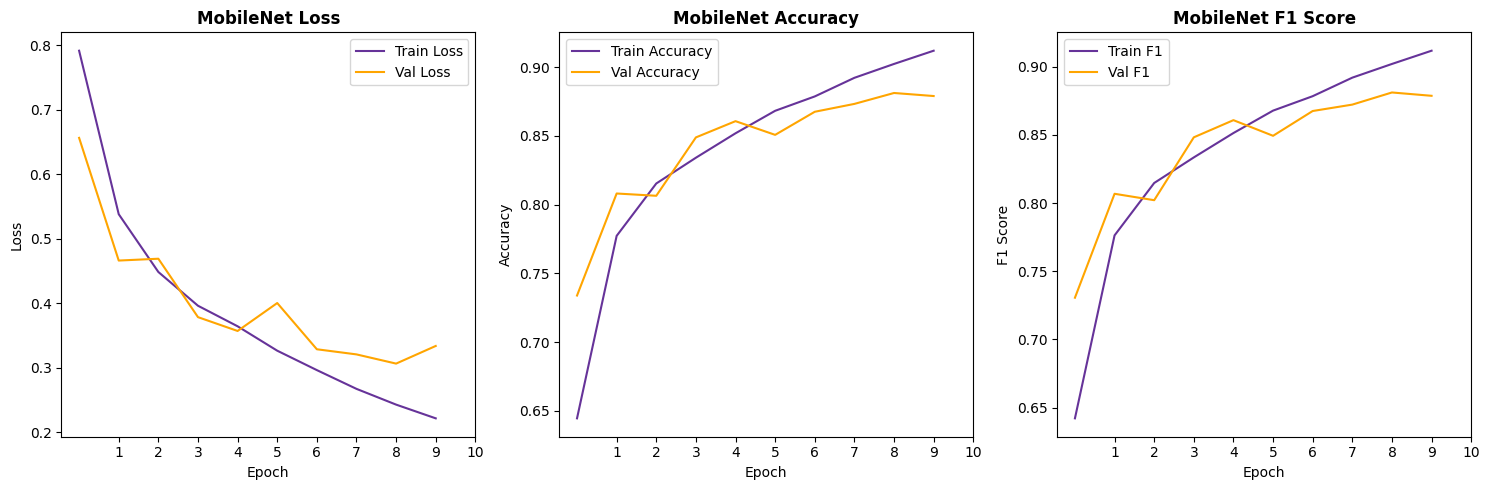

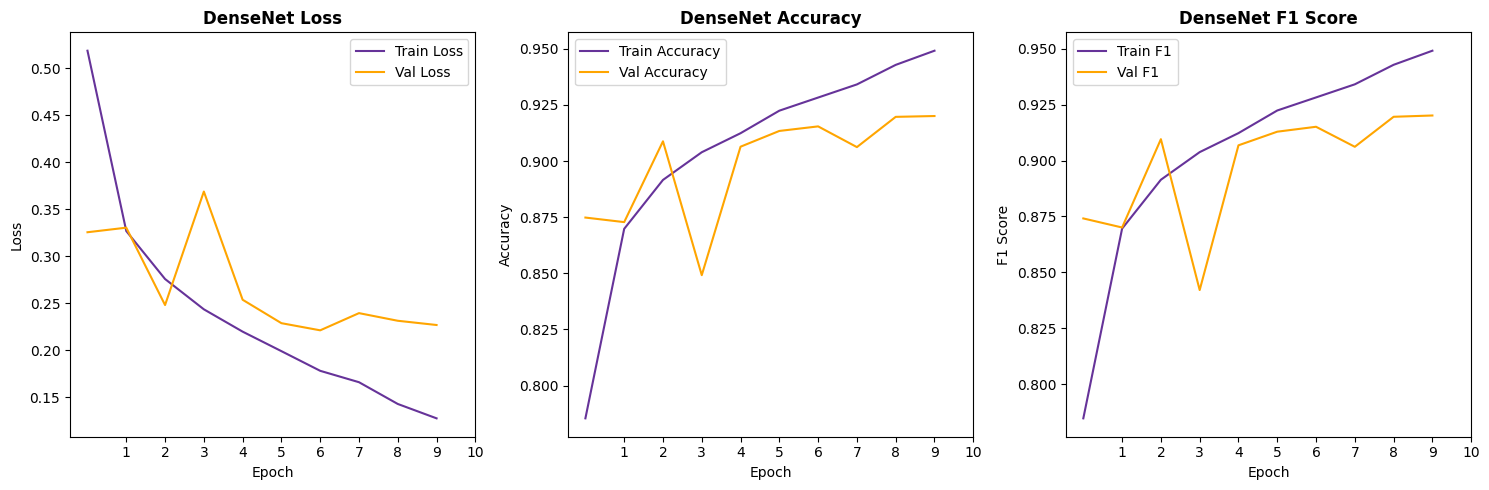

In [ ]:
def plot_metrics(metrics, model_name):
    epochs = np.arange(1, len(metrics['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(metrics['train_loss'], label='Train Loss', color = "rebeccapurple")
    plt.plot(metrics['val_loss'], label='Val Loss', color = "orange")
    plt.title(f'{model_name} Loss', weight="bold")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy', color = "rebeccapurple")
    plt.plot(metrics['val_acc'], label='Val Accuracy', color = "orange")
    plt.title(f'{model_name} Accuracy', weight="bold")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(metrics['train_f1'], label='Train F1', color = "rebeccapurple")
    plt.plot(metrics['val_f1'], label='Val F1', color = "orange")
    plt.title(f'{model_name} F1 Score', weight="bold")
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(metrics_mobilenet, "MobileNet")
plot_metrics(metrics_densenet, "DenseNet")

# Final Evaluation & Comparison

In [ ]:
# Evaluation on test set
def test_model(model, loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'COVID-19', 'Pneumonia'])
    disp.plot(cmap='YlGnBu')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # classification report
    print(f"\n{model_name} Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=['Normal', 'COVID-19', 'Pneumonia'], output_dict=True) # for later comparison
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'COVID-19', 'Pneumonia']))

    acc = accuracy_score(all_labels, all_preds) # for later comparison

    return report, acc

MobileNet Test Evaluation:


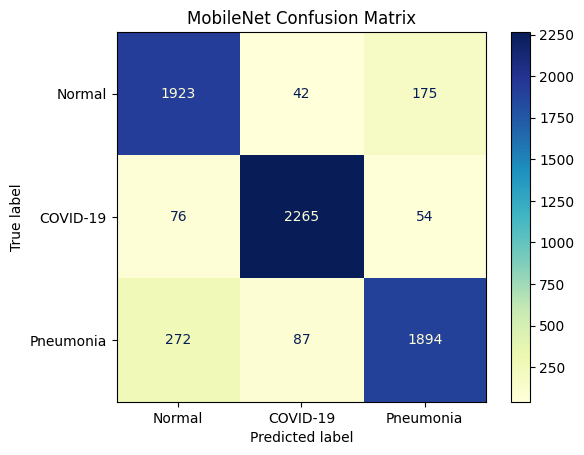


MobileNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.90      0.87      2140
    COVID-19       0.95      0.95      0.95      2395
   Pneumonia       0.89      0.84      0.87      2253

    accuracy                           0.90      6788
   macro avg       0.90      0.89      0.89      6788
weighted avg       0.90      0.90      0.90      6788



In [ ]:
# loading the best model
mobilenet.load_state_dict(torch.load("best_mobilenet.pt", weights_only=True))

# Test evaluation
print("MobileNet Test Evaluation:")
report_mobilenet, acc_mobilenet = test_model(mobilenet, test_loader, "MobileNet")

DenseNet Test Evaluation:


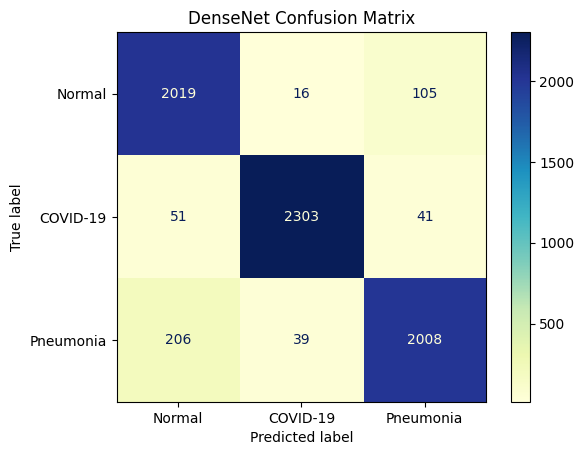


DenseNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.94      0.91      2140
    COVID-19       0.98      0.96      0.97      2395
   Pneumonia       0.93      0.89      0.91      2253

    accuracy                           0.93      6788
   macro avg       0.93      0.93      0.93      6788
weighted avg       0.93      0.93      0.93      6788



In [ ]:
# loading the best model
densenet.load_state_dict(torch.load("best_densenet.pt", weights_only=True))

# Test evaluation
print("DenseNet Test Evaluation:")
report_densenet, acc_densenet = test_model(densenet, test_loader, "DenseNet")

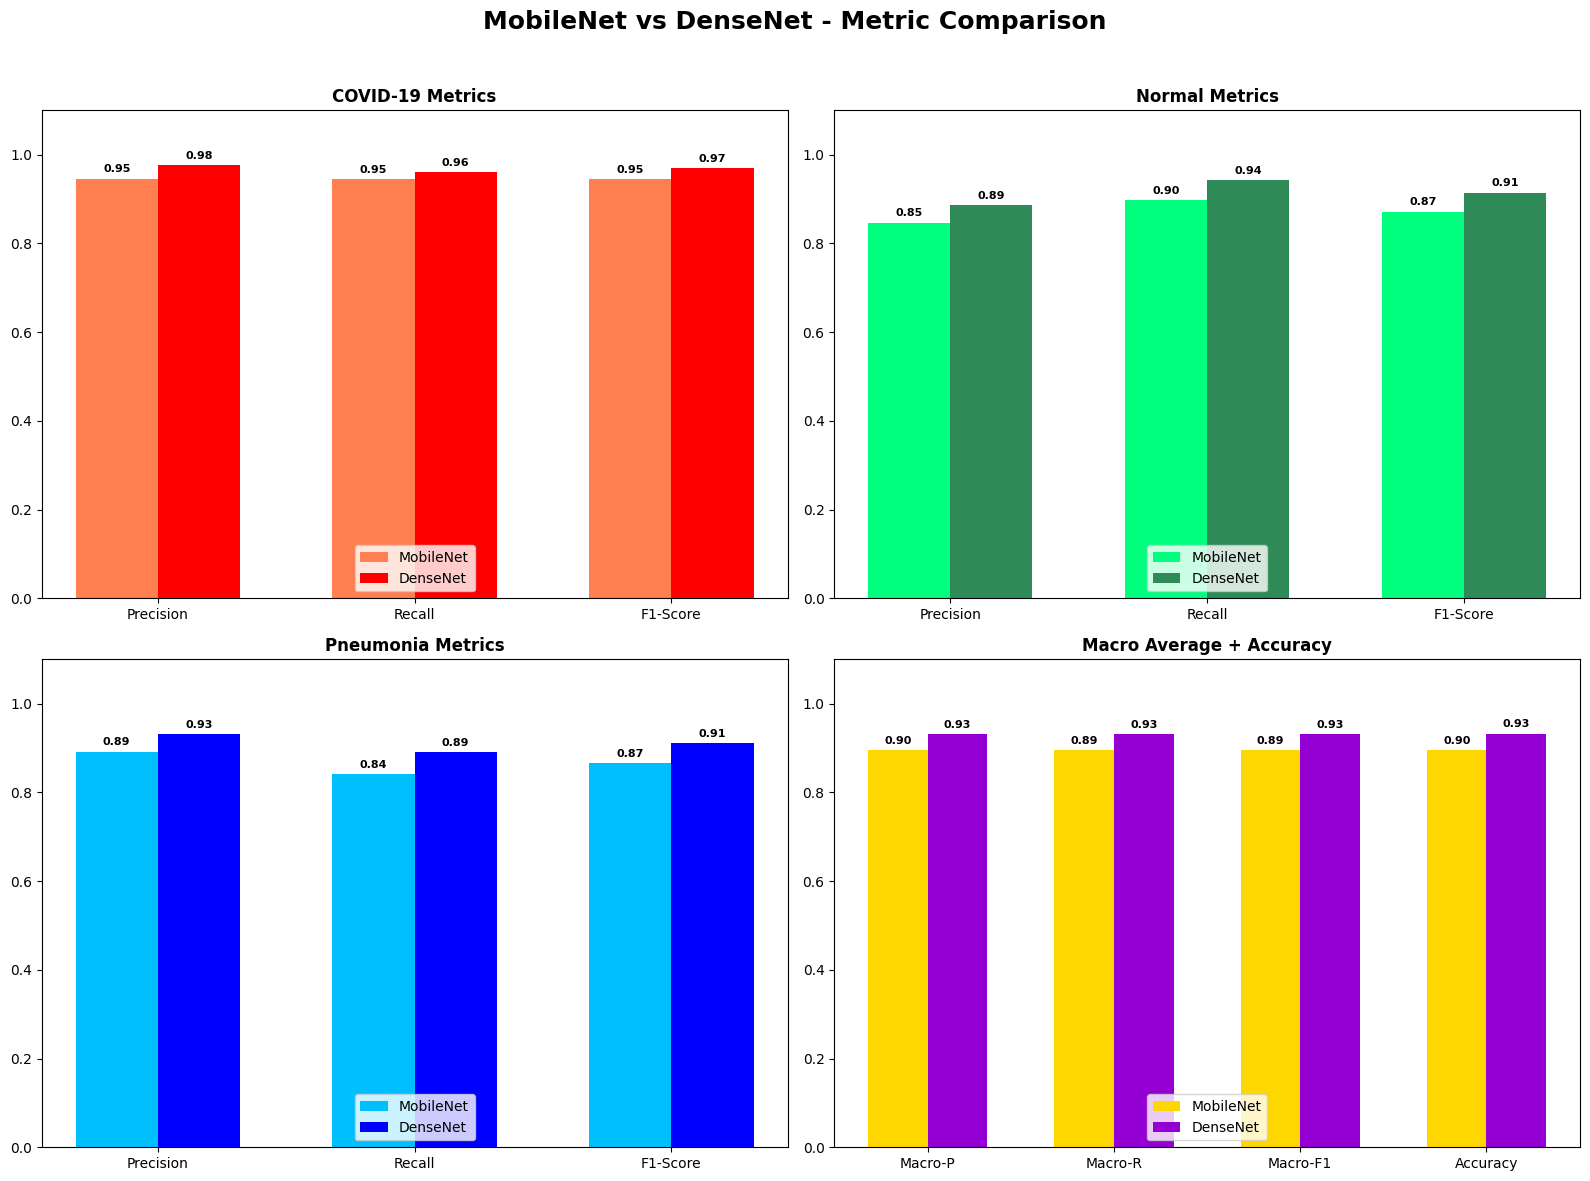

In [ ]:
# Per-Class COVID-19 metrics
covid_mobilenet = [
    report_mobilenet['COVID-19']['precision'],
    report_mobilenet['COVID-19']['recall'],
    report_mobilenet['COVID-19']['f1-score']
]
covid_densenet = [
    report_densenet['COVID-19']['precision'],
    report_densenet['COVID-19']['recall'],
    report_densenet['COVID-19']['f1-score']
]

# Per-Class Normal metrics
normal_mobilenet = [
    report_mobilenet['Normal']['precision'],
    report_mobilenet['Normal']['recall'],
    report_mobilenet['Normal']['f1-score']
]
normal_densenet = [
    report_densenet['Normal']['precision'],
    report_densenet['Normal']['recall'],
    report_densenet['Normal']['f1-score']
]

# Per-Class Pneumonia metrics
pneumonia_mobilenet = [
    report_mobilenet['Pneumonia']['precision'],
    report_mobilenet['Pneumonia']['recall'],
    report_mobilenet['Pneumonia']['f1-score']
]
pneumonia_densenet = [
    report_densenet['Pneumonia']['precision'],
    report_densenet['Pneumonia']['recall'],
    report_densenet['Pneumonia']['f1-score']
]

# Macro avg + Accuracy
macro_mobilenet = [
    report_mobilenet['macro avg']['precision'],
    report_mobilenet['macro avg']['recall'],
    report_mobilenet['macro avg']['f1-score'],
    acc_mobilenet
]
macro_densenet = [
    report_densenet['macro avg']['precision'],
    report_densenet['macro avg']['recall'],
    report_densenet['macro avg']['f1-score'],
    acc_densenet
]


def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, weight="bold")


x_labels_perclass = ['Precision', 'Recall', 'F1-Score']
x_labels_macro = ['Macro-P', 'Macro-R', 'Macro-F1', 'Accuracy']
x_small = np.arange(len(x_labels_perclass))
x_macro = np.arange(len(x_labels_macro))

width = 0.32
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MobileNet vs DenseNet - Metric Comparison', fontsize=18, weight="bold")

# Subplot 1: COVID-19
ax = axes[0, 0]
rects1 = ax.bar(x_small - width/2, covid_mobilenet, width, label='MobileNet', color='coral')
rects2 = ax.bar(x_small + width/2, covid_densenet, width, label='DenseNet', color='red')
ax.set_title('COVID-19 Metrics', weight="bold")
ax.set_xticks(x_small)
ax.set_xticklabels(x_labels_perclass)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower center")
autolabel(ax, rects1)
autolabel(ax, rects2)

# Subplot 2: Normal
ax = axes[0, 1]
rects1 = ax.bar(x_small - width/2, normal_mobilenet, width, label='MobileNet', color='springgreen')
rects2 = ax.bar(x_small + width/2, normal_densenet, width, label='DenseNet', color='seagreen')
ax.set_title('Normal Metrics', weight="bold")
ax.set_xticks(x_small)
ax.set_xticklabels(x_labels_perclass)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower center")
autolabel(ax, rects1)
autolabel(ax, rects2)

# Subplot 3: Pneumonia
ax = axes[1, 0]
rects1 = ax.bar(x_small - width/2, pneumonia_mobilenet, width, label='MobileNet', color='deepskyblue')
rects2 = ax.bar(x_small + width/2, pneumonia_densenet, width, label='DenseNet', color='blue')
ax.set_title('Pneumonia Metrics', weight="bold")
ax.set_xticks(x_small)
ax.set_xticklabels(x_labels_perclass)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower center")
autolabel(ax, rects1)
autolabel(ax, rects2)

# Subplot 4: Macro Avg + Accuracy
ax = axes[1, 1]
rects1 = ax.bar(x_macro - width/2, macro_mobilenet, width, label='MobileNet', color='gold')
rects2 = ax.bar(x_macro + width/2, macro_densenet, width, label='DenseNet', color='darkviolet')
ax.set_title('Macro Average + Accuracy', weight="bold")
ax.set_xticks(x_macro)
ax.set_xticklabels(x_labels_macro)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower center")
autolabel(ax, rects1)
autolabel(ax, rects2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()